# Traffic Sign Recognition with Convolutional Neural Networks

---

Dr.-Ing. Antje Muntzinger, Hochschule für Technik Stuttgart

antje.muntzinger@hft-stuttgart.de

---

### Domain Background
Autonomous driving is one of the main research areas of artificial intelligence and machine learning.
Traffic sign recognition has been available in advanced driver assistance systems since 2008
(https://en.wikipedia.org/wiki/Traffic-sign_recognition). Although research has been done for
many years in this domain, there are still unsolved problems, such as computer vision in bad
weather conditions, at nighttime, or additional traffic signs that are difficult to classify.

### Problem Statement
In this notebook we will implement a traffic sign detector. The detector should get images
of traffic signs of different classes as input and return the most likely class as output.

---
## 0. Working with GPUs in Google Colab

You can run this notebook locally on your computer, but for free GPU access, you can use Google Colab to accelerate training. Here is a quick summary on how to work with Google Colab:
- You will need a Gmail-Account.
- Go to drive.google.com and create a new folder for your code, e.g. called "app".
- Upload this jupyter notebook in the new folder and open it.
- In the menu, select **Runtime** -> **Change runtime type** and select **T4 GPU** as Hardware accelerator.
- Select **Runtime** -> **Run all cells** and accept all requested access rights.

Unfortunately, GPU usage in Colab is restrected and you may not always have access to a GPU.

**Note that some of the cells in this notebook may take hours to complete, so use all 3 weeks for this assignment! Intensive training may have to run overnight. Don't start working on the assignment last minute, you will not be able to complete it.**

---
## 1. PyTorch Tutorial

### Introduction to PyTorch

Work through the ["Introduction to PyTorch" tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) consisting of nine topics:

*   Learn the Basics
*   Quickstart
*   Tensors
*   Datasets & DataLoaders
*   Transforms
*   Build Model
*   Autograd
*   Optimization
*   Save & Load Model

You can run each part in Colab and inspect / modify the code and data. There are certainly some details that you do not yet understand. Don't let that stop you, but try to get a good overall view on working with PyTorch.



**TODO:** 1a) Why does PyTorch have a dedicated tensor data structure (`torch.tensor`) and does not use NumPy multidimensional arrays exclusively?  **(2 points)**

**ANSWER:** NumPy is a library dedicated to numerical computation, on the other hand, PyTorch is a library tought to be used in deepleanring, we can see that for example when creating a matrix in Pytorch the standard type of the elements of the mat if float32, insted of float64 that we get in NumPy. PyTorch tensors are designed to seamlessly work with GPUs. One of PyTorch's standout features is its automatic differentiation engine (autograd). PyTorch tensors support automatic differentiation, meaning gradients can be computed for tensor operations, which is essential for training machine learning models via backpropagation. 

**TODO:** 1b) In the ["Build Model"](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) section of the tutorial, there is a definition of a neural network, as follows:


```
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
```

Explain the different parameters of the `nn.Linear()` layers. How are the numeric values, `28*28`, `512` and `10`, determined?  **3 points)**

**ANSWER:**  
$28*28$ is the size of the image 
512 is a design choice ==> number of neurons in the hidden layer
10 is the number of calsses ==> number of neurons in the output layer
nn.Linear($28*28$, 512) ==> it is a fullyconnected layer that takes in input 784 = $28*28$ features and puts out 512 features  
nn.Linear(512, 512) ==> it is a fullyconnected layer that takes in input 512 features and puts out 512 features 
nn.Linear(512, 10) ==> it is a fullyconnected layer that takes in input 512 features and puts out 10 features 


**TODO:** 1c) In the ["Build Model"](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) section of the tutorial, it is stated that `nn.Softmax()` is applied on the logits. Can you explain why this is needed? Is the softmax function applied on the output of every neural network, or only in special cases, and if so, in which cases? **(2 points)**

**ANSWER:** We are trying to do traffic sign classifier because of that we need to do classification and we use softmax function for classification problems which has more than 2 labels. It is used in the last layer, its objective is, given the input to the last layer,  compute the probability that an input belongs to each classes, the sum of all the probability must be 1. We dont use softmax on reggression problems so it is not be used in every network. If we have 2 labels we will use sigmoid, however sigmoid is special case of softmax, hence in every classification problem we use softmax function.

**TODO**: 1d) In the ["Optimization"](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) section of the tutorial, explain why `requires_grad=True` is set for `w` and `b`, but not for `x` and `y`. In which cases should we set `torch.no_grad()`? **(2 points)**

**ANSWER:** We use grads to tune the w and b so we change them. X and y is our data and we calculate grads from them. If we dont want to the grads being calculated on test mode then we can use torch.no_grad().


**TODO:** 1e) In the ["Optimization"](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) section of the tutorial, an example of a training loop is given:

 ```
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
 ```

 Explain the effect of the function calls `optimizer.zero_grad()` and `optimizer.step()`.
 **(2 points)**

 **Note:** It is a very common bug to forget `optimizer.zero_grad()`, so keep in mind why it is needed, this might save you a lot of time debugging!


**ANSWER:** Gradients increase up by default, thus we intentionally zero them at each iteration to avoid double counting. After obtaining our gradients, we utilize optimizer.step() to modify the parameters based on the gradients gathered during the reverse run.

---
## 2. Data Exploration

### Datasets and Inputs
In order to classify traffic signs, we will use the German Traffic Sign Recognition Benchmark (GTSRB). The training and testing sets are available as PyTorch datasets.

The German Traffic Sign Recognition Benchmark is a multi-class, single-image classification challenge. It contains images from 43 classes in total and is a large, lifelike database. The images are taken in different angles and lighting conditions. Therefore, the use of this dataset is appropriate given the context of the problem.

### Data Exploration and Pre-Processing

First, we will load the data and explore the given images. We will write some basic
code to see how the images look like, how the data is organized and decide which modifications
have to be done. We will also perform a split into training, validation and testing data. Further, the image data should be normalized so that the data has mean zero and equal variance. We will use data augmentation techniques as well.


In [1]:
# Package Path (this needs to be adapted)
packagePath = "./models/" # local
colab = False
if 'google.colab' in str(get_ipython()):
    colab = True
    packagePath = '/content/drive/My Drive/Colab_Notebooks/Traffic_Sign_Classifier/'   # Colab

In [2]:
# install required packages specified in pipfile (not required in colab)
if not colab:
    !pipenv install

Installing dependencies from Pipfile.lock (e5b035)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.


In [7]:
!pipenv install

Installing dependencies from Pipfile.lock (e5b035)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.


In [3]:
# imports:

# NumPy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# if colab:
#     !pip install torchinfo
from torchinfo import summary


In [4]:
# calc mean and standard deviation for normalization
def calc_stats(data):

    dataloader = torch.utils.data.DataLoader(data, batch_size=1)
    total_mean =[0, 0, 0]
    total_std =[0, 0, 0]
    for image, label in dataloader:
        np_image = image.numpy()
        # print(np_image.shape) # shape is (batch_size, 3, height, width) - height and width vary, so we have to resize below
        mean = np.mean(np_image, axis=(0,2,3)) # normalize each color channel separately
        # alternative
        # mean_red = np.mean(np_image[:,0,:,:])
        # mean_green = np.mean(np_image[:,1,:,:])
        # mean_blue = np.mean(np_image[:,2,:,:])
        total_mean += mean
        std = np.std(np_image, axis=(0,2,3))
        total_std += std

    total_mean /= len(dataloader)
    total_std /= len(dataloader)
    return total_mean, total_std

In [5]:
# load data
train = torchvision.datasets.GTSRB(root='./data', split='train', transform=transforms.ToTensor())
mean_train, std_train = calc_stats(train)
print("Image mean for training data is ", mean_train)
print("Image standard deviation for training data is ", std_train)
test = torchvision.datasets.GTSRB(root='./data', split='test', transform=transforms.ToTensor())
mean_test, std_test = calc_stats(test)
print("Image mean for test data is ", mean_test)
print("Image standard deviation for test data is ", std_test)

Image mean for training data is  [0.3416956  0.31255513 0.3215493 ]
Image standard deviation for training data is  [0.16791918 0.16777296 0.1779353 ]
Image mean for test data is  [0.33733056 0.30955206 0.32079183]
Image standard deviation for test data is  [0.16980827 0.16943275 0.18073833]


**TODO**: 2) Define the following transforms and store them in variables called `train_transform` and `test_transform`, respectively:
- resize the images to `imHeight` times `imWidth`
- randomly rotate around 30 degrees
- convert the images to tensor format and
- normalize mean and standard deviation (we have calculated the values above).

The transforms will be applied afterwards (this code is provided).
Check out the documentation here: https://pytorch.org/vision/stable/transforms.html
**(4 points)**

In [6]:
# different parameters
batchSize = 12 # numer of images loaded and processed at once. Larger batch sizes enable faster training, but can lead to overfitting and lower accuracy.
imWidth = 64 # resize to images of this width
imHeight = 64 # resize to images of this width
load_model_from_file = False # load checkpoint instead of training - skip the training loop if True

###### TODO: YOUR CODE GOES HERE #####
from torchvision.transforms import v2

train_transform = v2.Compose([
    v2.Resize((imWidth, imHeight)),
    v2.RandomRotation(30),
    v2.ToTensor(),
    v2.Normalize(mean=mean_train, std=std_train),
])

test_transform = v2.Compose([
    v2.Resize((imWidth, imHeight)),
    v2.RandomRotation(30),
    v2.ToTensor(),
    v2.Normalize(mean=mean_test, std=std_test),
])

##### END STUDENT CODE

# get training data
trainSet = torchvision.datasets.GTSRB(root='./data', split='train',
                                      download=True, transform=train_transform)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True)
numTrainSamples = len(trainSet)
print('number of training samples:', numTrainSamples)

# get validation and test data
gtsrbTestSet = torchvision.datasets.GTSRB(root='./data', split='test',
                                          download=True, transform=test_transform)

# split the original GTSRB test data into 75% validation data and 25% test data
length75Percent = int(0.75 * len(gtsrbTestSet))
length25Percent = len(gtsrbTestSet) - length75Percent
lengths = [length75Percent, length25Percent]
valSet, testSet = torch.utils.data.random_split(gtsrbTestSet, lengths)

# validation data
validLoader = torch.utils.data.DataLoader(valSet, batch_size=batchSize, shuffle=True)
numValSamples = len(valSet)
print('number of validation samples:', numValSamples)

# test data
testLoader = torch.utils.data.DataLoader(testSet, batch_size=1, shuffle=True)
numTestSamples = len(testSet)
print('number of test samples:', numTestSamples)

# Available traffic sign classes in the dataset
classes = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons",
]

numClasses = len(classes)

c:\Users\enes_\.virtualenvs\Assignment_3-QMV5D0kI\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


number of training samples: 26640
number of validation samples: 9472
number of test samples: 3158


### Visualization of the dataset

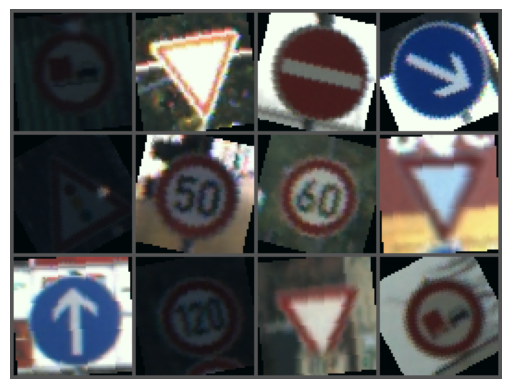

In [7]:
# Visualize a random batch of data from the data set

def imshow(img):
    npimg = img.cpu().numpy() # make sure image is in host memory

    # normalize to 0-1 for visualization
    minPixel = np.min(npimg)
    maxPixel = np.max(npimg)
    npimg = npimg - minPixel
    npimg = npimg / (maxPixel-minPixel)

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()


numRows = 4

# get a single random batch of training images
dataIter = iter(trainLoader)
images, labels = next(dataIter)

# show images
imshow(torchvision.utils.make_grid(images, nrow=numRows))

----

## 3. Implementation of a Fully Connected Neural Network (FCN)


Our first neural network is an FCN to solve the image classification. The FCN should get an image as input and give the probabilities of the classes as output.

**Note:** The abbreviation FCN is often also used for a "fully convolutional neural network" - don't get confused, here we use it for "fully connected neural network".


### Model Architecture

**TODO**: 3a) Design a fully connected model architecture as seen in the tutorial https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html, i.e., define a subclass of `nn.Module` and name it `FCN`. Then define the `__init__()` and `forward()` functions. The network should have the following shape:
- a linear layer `torch.nn.Linear` with input size `imWidth*imHeight*3` and output size 512, followed by a ReLU activation `torch.nn.functional.relu`,
- another linear layer `torch.nn.Linear` with input size 512 and output size `numClasses`, followed by a LogSoftmax function `torch.nn.LogSoftmax` (without ReLU activation).

You should also define an optimizer with a learning rate (e.g. Adam optimizer with learning rate 0.0001) and a loss function, the negative log likelihood loss `torch.nn.functional.NLLLoss`.

The `forward()` function should do a forward pass of an image through the network (note that the image has to be flattened first).
**(8 points)**

**Note:** We use a negative log likelihood loss as loss function, which expects the logarithm of predicted class probabilities as input, therefore we use LogLoss as last layer of the network. The output is therefore not the final class probabilities - to get these, we calculate the exponential of the output, which you will see several times below (this code is provided). Alternatively, we could also apply a Cross Entropy Loss on the raw logits, which is equivalent. Further details: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.

In [8]:
###### TODO: YOUR CODE GOES HERE #####
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(imWidth * imHeight * 3, 512),
            nn.ReLU(),
            nn.Linear(512, numClasses),
            nn.LogSoftmax()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.loss = torch.nn.NLLLoss()
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        
        return logits


In [9]:
# create the model and print summary using torchinfo
model_fcn = FCN()
summary(model_fcn, input_size=(1, 3, 64, 64), row_settings=["var_names"])

c:\Users\enes_\.virtualenvs\Assignment_3-QMV5D0kI\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type (var_name))                  Output Shape              Param #
FCN (FCN)                                [1, 43]                   --
├─Flatten (flatten)                      [1, 12288]                --
├─Sequential (layers)                    [1, 43]                   --
│    └─Linear (0)                        [1, 512]                  6,291,968
│    └─ReLU (1)                          [1, 512]                  --
│    └─Linear (2)                        [1, 43]                   22,059
│    └─LogSoftmax (3)                    [1, 43]                   --
Total params: 6,314,027
Trainable params: 6,314,027
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.31
Input size (MB): 0.05
Forward/backward pass size (MB): 0.00
Params size (MB): 25.26
Estimated Total Size (MB): 25.31

### Training

When the model architecture is defined, the model has to be trained. We will use Google
Colab in order to accelerate training with GPU support. During training, we will monitor train and
test losses to avoid overfitting. We will also evaluate accuracy improvement during training on a
validation set.

In [10]:
# initialize parameter (not inside next cell to enable reloading of model)
total_acc = 0
train_losses = []
valid_losses = []

In [11]:
# train loop
def run_training(model, num_episodes, print_every, trainLoader, filename, total_acc, train_losses, valid_losses):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('device =',device)
    model.to(device)

    steps = 0
    running_loss = 0

    for i_episode in range(num_episodes):
        for inputs, labels in trainLoader:
            steps += 1

            # move input and label tensors to the default device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero gradients (remove gradients from previous training batches, otherwise they get accumulated)
            model.optimizer.zero_grad()

            # forward pass through network
            logps = model.forward(inputs)

            # calculate loss
            loss = model.loss(logps, labels)

            # backpropagation
            loss.backward()

            # update weights with an optimizer step
            model.optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0 or i_episode == len(trainLoader)-1:
                valid_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in validLoader:

                        # Move input and label tensors to the default device
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        logps = model.forward(inputs)
                        batch_loss = model.loss(logps, labels)
                        valid_loss += batch_loss.item()

                        # Calculate accuracy
                        ps = torch.exp(logps) # the model outputs log probabilities, so we need the exponential to negate the log for actual class probabilities
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                accuracy /= len(validLoader)
                valid_loss /= len(validLoader)
                running_loss /= print_every
                train_losses.append(running_loss)
                valid_losses.append(valid_loss)
                print(f"Epoch {i_episode+1}/{num_episodes}.. "
                    f"Train loss: {running_loss:.3f}.. "
                    f"Valid loss: {valid_loss:.3f}.. "
                    f"Valid accuracy: {accuracy:.3f}")
                running_loss = 0
                model.train()
                if accuracy > total_acc:
                    total_acc = accuracy
                    print("Accuracy improved! Saving model...")

                    # save the checkpoint
                    model.to('cpu')
                    checkpoint = {'opt_state': model.optimizer.state_dict,
                                'total_acc': total_acc,
                                'train_losses': train_losses,
                                'valid_losses': valid_losses,
                                'state_dict': model.state_dict()}
                    torch.save(checkpoint, packagePath+filename)
                    model.to(device)
                else:
                    print("Accuracy not improved. Continuing without saving model...")
                print(f"Last accuracy: {accuracy:.3f}")
                print(f"Best accuracy: {total_acc:.3f}\n")

    model.to('cpu')


In [91]:
# training parameters
print_every = 1000 #np.inf
num_episodes = 20

# run train loop
if not load_model_from_file:
    run_training(model_fcn, num_episodes, print_every, trainLoader, 'fcn_checkpoint.pth', total_acc, train_losses, valid_losses)

device = cpu
Epoch 1/20.. Train loss: 2.140.. Valid loss: 2.003.. Valid accuracy: 0.504
Accuracy improved! Saving model...
Last accuracy: 0.504
Best accuracy: 0.504

Epoch 1/20.. Train loss: 1.230.. Valid loss: 1.686.. Valid accuracy: 0.562
Accuracy improved! Saving model...
Last accuracy: 0.562
Best accuracy: 0.562

Epoch 2/20.. Train loss: 0.991.. Valid loss: 1.710.. Valid accuracy: 0.602
Accuracy improved! Saving model...
Last accuracy: 0.602
Best accuracy: 0.602

Epoch 2/20.. Train loss: 0.887.. Valid loss: 1.615.. Valid accuracy: 0.642
Accuracy improved! Saving model...
Last accuracy: 0.642
Best accuracy: 0.642

Epoch 3/20.. Train loss: 0.738.. Valid loss: 1.599.. Valid accuracy: 0.643
Accuracy improved! Saving model...
Last accuracy: 0.643
Best accuracy: 0.643

Epoch 3/20.. Train loss: 0.684.. Valid loss: 1.597.. Valid accuracy: 0.677
Accuracy improved! Saving model...
Last accuracy: 0.677
Best accuracy: 0.677

Epoch 4/20.. Train loss: 0.650.. Valid loss: 1.844.. Valid accuracy: 

In [13]:
# function that loads a checkpoint and rebuilds the model (optional)
def load_checkpoint(filepath, model_type):
    try:
        checkpoint = torch.load(filepath)
    except:
        checkpoint = torch.load(filepath, map_location=torch.device('cpu')) # catch exception when colab has no GPU available

    if model_type == 'fcn':
        model = FCN()
    else:
        model = CNN()

    model.load_state_dict(checkpoint['state_dict'], strict=False)
    total_acc = checkpoint['total_acc']
    train_losses = checkpoint['train_losses']
    valid_losses = checkpoint['valid_losses']

    return model, total_acc, train_losses, valid_losses

In [ ]:
# load the checkpoint (optional for re-starting where you left)
model_fcn, total_acc, train_losses, valid_losses = load_checkpoint(packagePath+'fcn_checkpoint.pth', 'fcn')

In [ ]:
# change learnrate for next epochs (activate in case you reloaded the model and want to re-run the training loop above)
# model_fcn.optimizer = optim.Adam(model_fcn.parameters(), lr=0.00001)

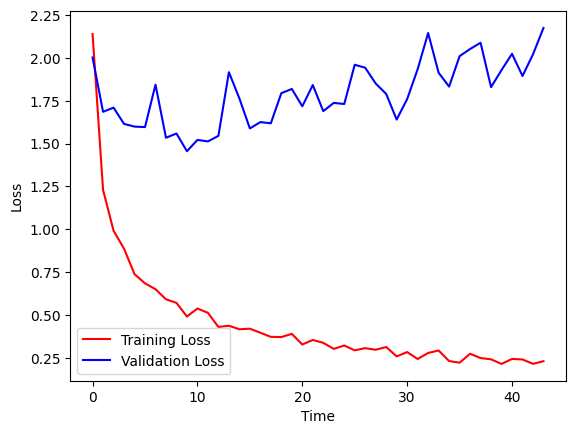

In [92]:
# plot losses
plt.plot(train_losses, 'r', label='Training Loss')
plt.plot(valid_losses, 'b', label='Validation Loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.legend()

### Testing and Evaluation

Finally, we test the performance of the trained classifier on the test set.

In [12]:
# function to plot an image from dataloader
def show_image(img):
    img = img.numpy()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    img = np.transpose(img, (1, 2, 0))

    # undo preprocessing
    mean = np.array(mean_train)
    std = np.array(std_train)
    img = std*img + mean

    # image needs to be clipped between 0 and 1
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.show()

Predicted class:  General caution (with probability 1.0)
True class:  Road work


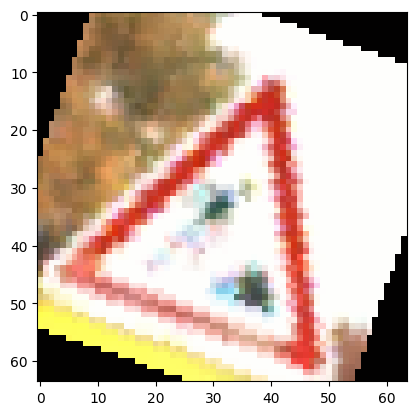

Predicted class:  Speed limit (80km/h) (with probability 0.9)
True class:  Speed limit (80km/h)


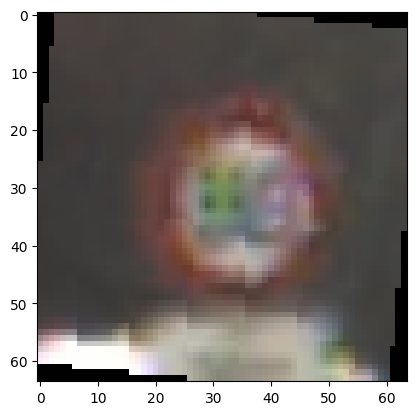

Predicted class:  Road work (with probability 0.9)
True class:  Road narrows on the right


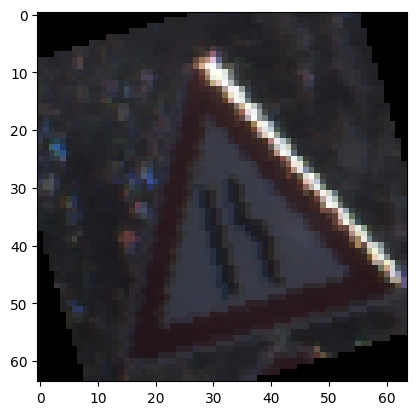

Predicted class:  Turn left ahead (with probability 1.0)
True class:  Turn left ahead


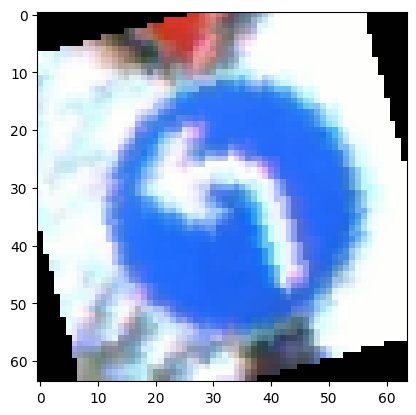

Predicted class:  Bumpy road (with probability 0.5)
True class:  Bicycles crossing


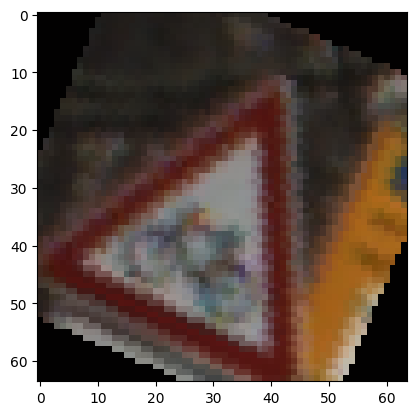

Predicted class:  Speed limit (70km/h) (with probability 0.7)
True class:  No vehicles


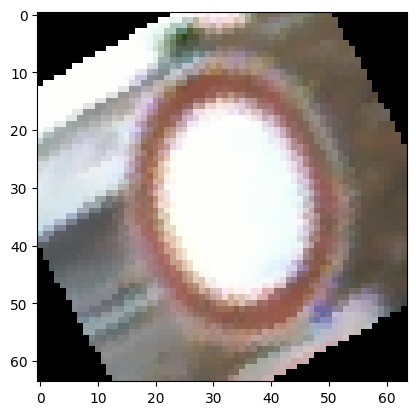

Predicted class:  Speed limit (70km/h) (with probability 1.0)
True class:  Speed limit (70km/h)


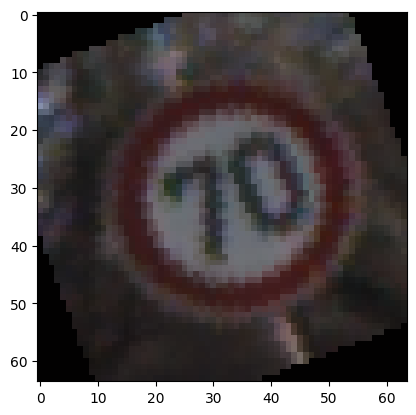

Predicted class:  Wild animals crossing (with probability 1.0)
True class:  Wild animals crossing


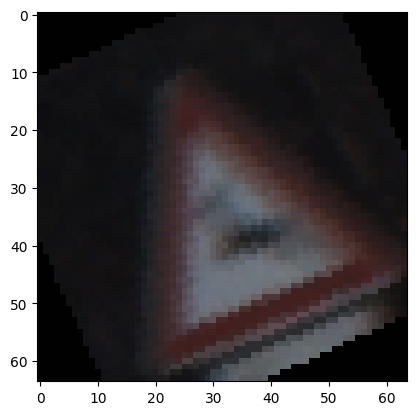

Predicted class:  Speed limit (120km/h) (with probability 0.6)
True class:  Speed limit (60km/h)


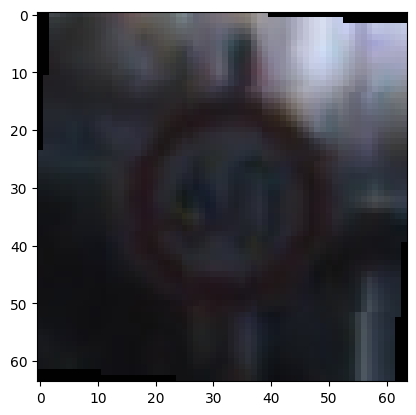

Predicted class:  General caution (with probability 0.7)
True class:  General caution


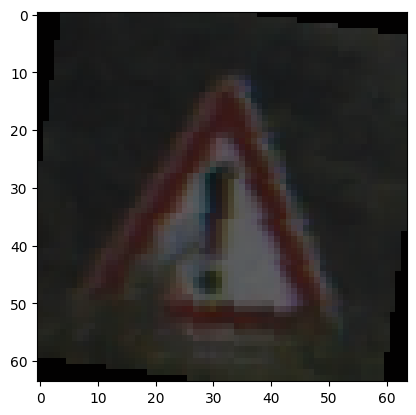

In [94]:
# plot 10 random images with predictions and labels
for i in range(10):
    dataiter = iter(testLoader)
    image, label = next(dataiter)

    outputs = model_fcn.forward(image)
    max_pred, class_pred = torch.max(outputs, 1)
    prob = torch.exp(max_pred) # again, use exp on log probabilities for real class probabilities
    print("Predicted class: ", classes[class_pred.item()], "(with probability %1.1f)" % prob.item())
    print("True class: ", classes[label.item()])

    show_image(torchvision.utils.make_grid(image))

In [13]:
# final evaluation on test data
def final_eval(model, testLoader):
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testLoader:

            logps = model.forward(inputs)

            # calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    accuracy /= len(testLoader)
    print(f"Final accuracy on test dataset: {accuracy:.3f}")


In [96]:
final_eval(model_fcn, testLoader)

Final accuracy on test dataset: 0.737


**TODO**: 3b) How do you interpret the results? Can you think of potential improvements?  **(2 points)**

**ANSWER:** The accuracy for this type of neural network is good actually. Because we don't have so much layers (not so deep network), epoch amount is not high, we can use different optimizers, we can change the batch amount, learning rate, data augmentation. We can add weight initialization.



----

## 4. Implementation of a Convolutional Neural Network (CNN)


In order to solve this classification problem, in practice we rather use a Convolutional Neural Network (CNN) than an FCN, because of translation and rotation invariance and computational efficiency. We will therefore implement a CNN and compare the results to the FCN.

### Model Architecture

**TODO**: 4) Design a CNN model architecture as seen in the tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, i.e., define a subclass of `nn.Module` and name it `CNN`. Then define the `__init__()` and `forward()` functions. The network should have the following shape (from input to output):
- a convolutional layer `torch.nn.Conv2d` with 3x3 kernels, input depth 3 (for the 3 color channels) and output depth 16, using `padding=1`, i.e. same padding to get the same output size as input size
- a MaxPooling `torch.nn.MaxPool2d` with 2x2 kernel
- a ReLU activation `torch.nn.functional.relu`
- a dropout layer `torch.nn.Dropout`
- a convolutional layer `torch.nn.Conv2d` with 3x3 kernels, input depth 16 and output depth 32, using same padding again
- a MaxPooling `torch.nn.MaxPool2d` with 2x2 kernel
- a ReLU activation `torch.nn.functional.relu`
- a convolutional layer `torch.nn.Conv2d` with 3x3 kernels, input depth 32 and output depth 64, using same padding again
- a MaxPooling `torch.nn.MaxPool2d` with 2x2 kernel
- a ReLU activation `torch.nn.functional.relu`
- a dropout layer `torch.nn.Dropout`
- a flattening layer
- a linear layer `torch.nn.Linear` with input size 4096 and output size `numClasses`
- a logsoftmax function `torch.nn.LogSoftmax` (without ReLU activation).

You should also define an optimizer with a learning rate (e.g. 0.0001) and a loss function, the negative log likelihood loss `torch.nn.functional.NLLLoss`.

The `forward()` function should do a forward pass of an image through the network (note that the image is **not** flattened first when using a CNN!).
**(10 points)**

In [27]:
###### TODO: YOUR CODE GOES HERE #####
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Flatten(),
            nn.Linear(4096, numClasses),
            nn.LogSoftmax()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.loss = nn.NLLLoss()
        
    def forward(self, X):
        logits = self.layers(X)
        
        return logits


**TODO**: 4b) Why is the input size to the linear layer 4096? **(2 points)**

**Hint**: You can find some infos regarding the output shape of a convolution layer here: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html.

**ANSWER:** Because by following the formula that we so in class W' = (W - K +2P)/S +1 and H' = (H - K +2P)/S +1
we take the data from the #CONVOLUTION 3 ==> W = H = 64 K = 3 P = 1 S = 1
the result that we get is W' = H' = 64 ==> $64*8*8$ = 4096




### Training



In [28]:
# create the model and print summary using torchinfo
model_cnn = CNN()
summary(model_cnn, input_size=(1, 3, 64, 64), row_settings=["var_names"])

Layer (type (var_name))                  Output Shape              Param #
CNN (CNN)                                [1, 43]                   --
├─Sequential (layers)                    [1, 43]                   --
│    └─Conv2d (0)                        [1, 16, 64, 64]           448
│    └─MaxPool2d (1)                     [1, 16, 32, 32]           --
│    └─ReLU (2)                          [1, 16, 32, 32]           --
│    └─Dropout (3)                       [1, 16, 32, 32]           --
│    └─Conv2d (4)                        [1, 32, 32, 32]           4,640
│    └─MaxPool2d (5)                     [1, 32, 16, 16]           --
│    └─ReLU (6)                          [1, 32, 16, 16]           --
│    └─Conv2d (7)                        [1, 64, 16, 16]           18,496
│    └─MaxPool2d (8)                     [1, 64, 8, 8]             --
│    └─ReLU (9)                          [1, 64, 8, 8]             --
│    └─Dropout (10)                      [1, 64, 8, 8]             --
│    └─

In [17]:
# initialize parameter (not inside next cell to enable reloading of model)
total_acc = 0
train_losses = []
valid_losses = []

In [18]:

# training parameters
print_every = 1000 #np.inf
num_episodes = 20

# training
if not load_model_from_file:
    run_training(model_cnn, num_episodes, print_every, trainLoader, 'cnn_checkpoint.pth', total_acc, train_losses, valid_losses)

device = cpu
Epoch 1/20.. Train loss: 3.032.. Valid loss: 2.557.. Valid accuracy: 0.316
Accuracy improved! Saving model...
Last accuracy: 0.316
Best accuracy: 0.316

Epoch 1/20.. Train loss: 1.927.. Valid loss: 1.899.. Valid accuracy: 0.460
Accuracy improved! Saving model...
Last accuracy: 0.460
Best accuracy: 0.460

Epoch 2/20.. Train loss: 1.485.. Valid loss: 1.669.. Valid accuracy: 0.516
Accuracy improved! Saving model...
Last accuracy: 0.516
Best accuracy: 0.516

Epoch 2/20.. Train loss: 1.236.. Valid loss: 1.498.. Valid accuracy: 0.565
Accuracy improved! Saving model...
Last accuracy: 0.565
Best accuracy: 0.565

Epoch 3/20.. Train loss: 1.076.. Valid loss: 1.352.. Valid accuracy: 0.611
Accuracy improved! Saving model...
Last accuracy: 0.611
Best accuracy: 0.611

Epoch 3/20.. Train loss: 0.948.. Valid loss: 1.275.. Valid accuracy: 0.623
Accuracy improved! Saving model...
Last accuracy: 0.623
Best accuracy: 0.623

Epoch 4/20.. Train loss: 0.858.. Valid loss: 1.236.. Valid accuracy: 

In [ ]:
# load the checkpoint (optional for re-training where you left)
model_cnn, total_acc, train_losses, valid_losses = load_checkpoint(packagePath+'cnn_checkpoint.pth', 'cnn')

In [ ]:
# change learnrate for next epochs (activate in case you reloaded the model and want to re-run the training loop above)
model_cnn.optimizer = optim.Adam(model_cnn.parameters(), lr=0.00001)

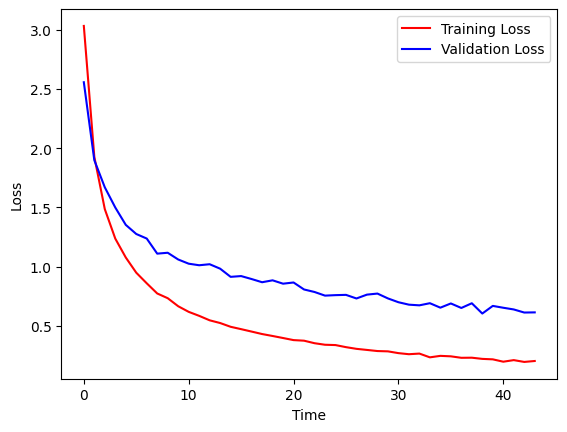

In [19]:
# plot losses
plt.plot(train_losses, 'r', label='Training Loss')
plt.plot(valid_losses, 'b', label='Validation Loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.legend()

### Testing and Evaluation

Finally, we test the performance of the trained classifier on the test set.

Predicted class:  Priority road (with probability 1.0)
True class:  Priority road


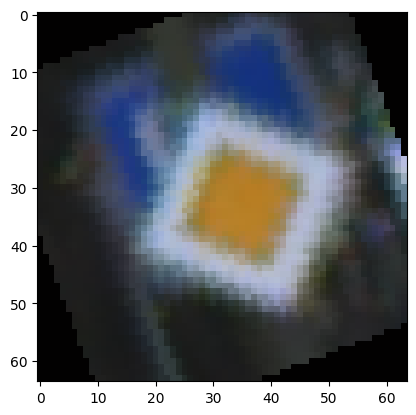

Predicted class:  Speed limit (80km/h) (with probability 0.8)
True class:  Speed limit (80km/h)


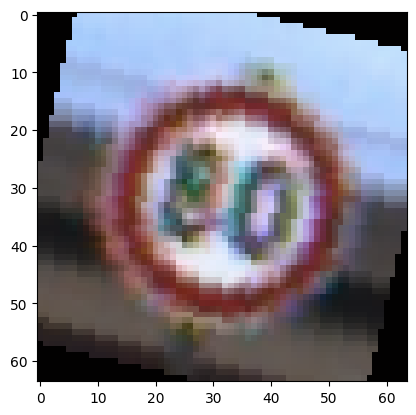

Predicted class:  Ahead only (with probability 0.9)
True class:  Keep right


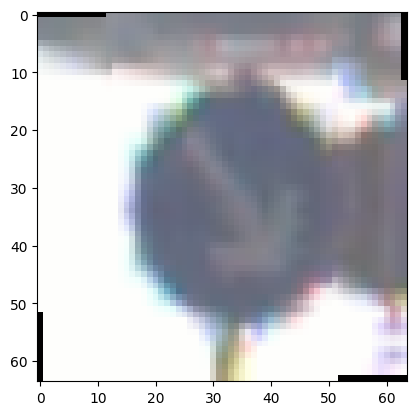

Predicted class:  General caution (with probability 0.6)
True class:  General caution


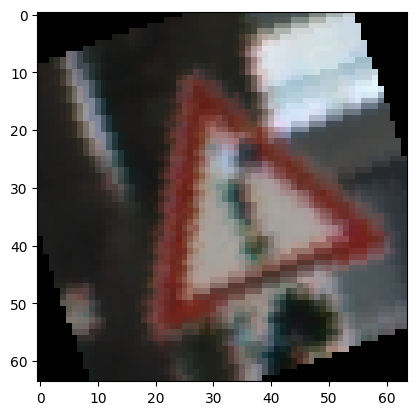

Predicted class:  Speed limit (80km/h) (with probability 0.5)
True class:  Speed limit (100km/h)


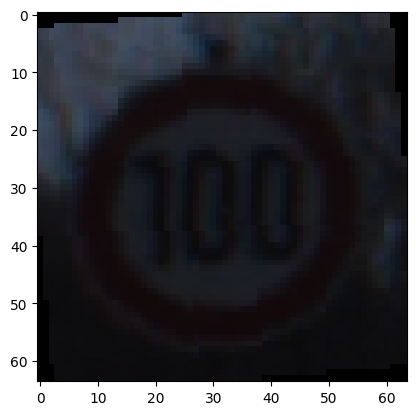

Predicted class:  Speed limit (100km/h) (with probability 1.0)
True class:  Speed limit (100km/h)


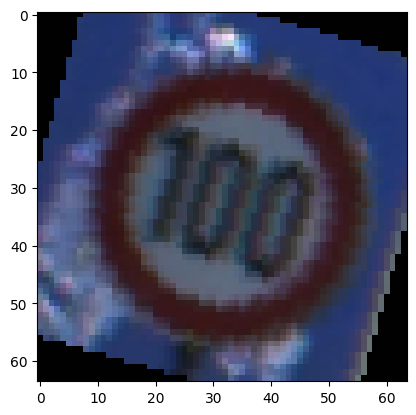

Predicted class:  Turn right ahead (with probability 1.0)
True class:  Turn right ahead


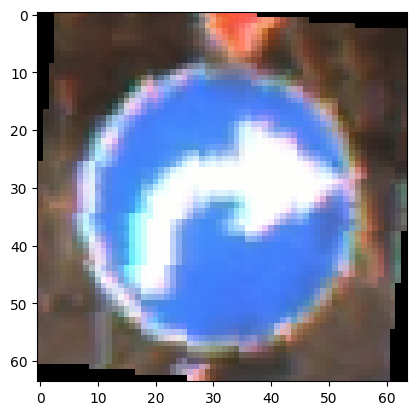

Predicted class:  Beware of ice/snow (with probability 0.6)
True class:  Beware of ice/snow


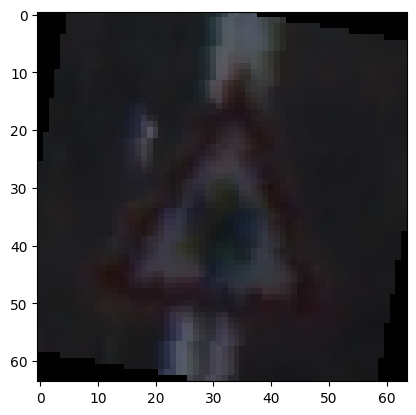

Predicted class:  Keep right (with probability 1.0)
True class:  Keep right


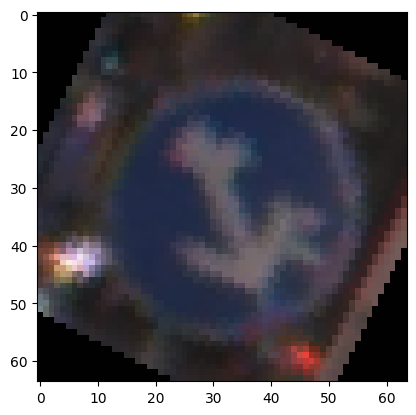

Predicted class:  Road work (with probability 0.7)
True class:  Beware of ice/snow


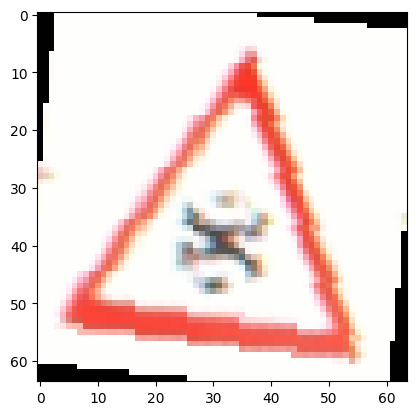

In [22]:
# plot 10 random images with predictions and labels
for i in range(10):
    dataiter = iter(testLoader)
    image, label = next(dataiter)

    outputs = model_cnn.forward(image)
    max_pred, class_pred = torch.max(outputs, 1)
    prob = torch.exp(max_pred)
    print("Predicted class: ", classes[class_pred.item()], "(with probability %1.1f)" % prob.item())
    print("True class: ", classes[label.item()])

    show_image(torchvision.utils.make_grid(image))

In [26]:
# final evaluation on testset
final_eval(model_cnn, testLoader)

Final accuracy on test dataset: 0.860


That's it! We have implemented and trained a fully connected neural network and a convolutional neural network for image classification of traffic signs in PyTorch :-)

## 5. Traffic Sign Recognition Challenge

**TODO**: 5) Tune your CNN above to achieve the best possible accuracy on the test set! Write a short comment below what you tried and whether it worked or not. The group with the best final accuracy on the test set will be awarded **+10 extra points**! **(6 points)**

**Hint:** Here are some suggestions how to improve your results (but there are many other options):
- Add regularization besides dropout, e.g. batch normalization layers
- Try a different optimizer
- Try a different architecture, e.g. more hidden layers or more nodes per layer (note that you will have to adapt the input size to the linear layer accordingly!)
- Try a different activation function, e.g. leaky ReLU
- Try more epochs / longer training times
- Change other hyperparameters, e.g., further decrease the learning rate after some epochs
- Add more data augmentation, see [this overview](https://pytorch.org/vision/stable/transforms.html)
- Try transfer learning, see [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- ...

**Note**: To really improve performance, you should train on GPUs, e.g. in Google Colab. But in case you have no access to GPUs (for example, sometimes GPUs in Colab are not available), you can still implement some of the suggestions above, it will help you practice, even though you might not see a massive improvement.

**ANSWER:**
new batchsize, new optimizer with learning decay and l2 regularization, more hidden fc layers, new kernel amounts and sizes, new pool layers, better data augmention, different learning rate

In [26]:
# different parameters
batchSize = 32 # we change the batch size for new network
imWidth = 64 
imHeight = 64 
load_model_from_file = False 

###### TODO: YOUR CODE GOES HERE #####
from torchvision.transforms import v2

train_transform = v2.Compose([
    v2.Resize((imWidth, imHeight)),
    v2.RandomRotation((0, 30)),         #adding rotation between 0 and 30 degrees
    v2.RandomPerspective(p=0.20),       #adding some random perspectives of images
    v2.ElasticTransform(5.0),           #we add some noise it looks like rainy day (camera has water on it)
    v2.ToTensor(),
    v2.Normalize(mean=mean_train, std=std_train),
])

test_transform = v2.Compose([
    v2.Resize((imWidth, imHeight)),
    v2.RandomRotation((0, 30)),
    v2.RandomPerspective(p=0.20),
    v2.ElasticTransform(5.0),
    v2.ToTensor(),
    v2.Normalize(mean=mean_test, std=std_test),
])

##### END STUDENT CODE

# get training data
trainSet = torchvision.datasets.GTSRB(root='./data', split='train',
                                      download=True, transform=train_transform)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True)
numTrainSamples = len(trainSet)
print('number of training samples:', numTrainSamples)

# get validation and test data
gtsrbTestSet = torchvision.datasets.GTSRB(root='./data', split='test',
                                          download=True, transform=test_transform)

# split the original GTSRB test data into 75% validation data and 25% test data
length75Percent = int(0.75 * len(gtsrbTestSet))
length25Percent = len(gtsrbTestSet) - length75Percent
lengths = [length75Percent, length25Percent]
valSet, testSet = torch.utils.data.random_split(gtsrbTestSet, lengths)

# validation data
validLoader = torch.utils.data.DataLoader(valSet, batch_size=batchSize, shuffle=True)
numValSamples = len(valSet)
print('number of validation samples:', numValSamples)

# test data
testLoader = torch.utils.data.DataLoader(testSet, batch_size=1, shuffle=True, drop_last=True)
numTestSamples = len(testSet)
print('number of test samples:', numTestSamples)

# Available traffic sign classes in the dataset
classes = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons",
]

numClasses = len(classes)

c:\Users\enes_\.virtualenvs\Assignment_3-QMV5D0kI\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


number of training samples: 26640
number of validation samples: 9472
number of test samples: 3158


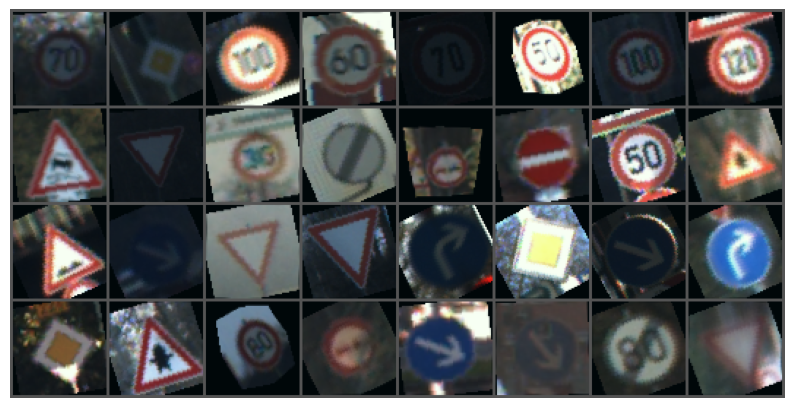

In [15]:
numRows = 8

# get a single random batch of training images
dataIter = iter(trainLoader)
images, labels = next(dataIter)

# show images
plt.figure(figsize = (10,10))
imshow(torchvision.utils.make_grid(images, nrow=numRows))

In [19]:
class CNN_2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, padding=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.AvgPool2d(2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(64*8*8, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, numClasses),
            nn.LogSoftmax()
        )
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5, centered=True)
        self.loss = nn.NLLLoss()
                
    def forward(self, X):
        logits = self.layers(X)
        
        return logits
    
                
                

In [20]:
# create the model and print summary using torchinfo
model_cnn_2 = CNN_2()
summary(model_cnn_2, input_size=(1, 3, 64, 64), row_settings=["var_names"])

Layer (type (var_name))                  Output Shape              Param #
CNN_2 (CNN_2)                            [1, 43]                   --
├─Sequential (layers)                    [1, 43]                   --
│    └─Conv2d (0)                        [1, 32, 64, 64]           2,432
│    └─MaxPool2d (1)                     [1, 32, 32, 32]           --
│    └─BatchNorm2d (2)                   [1, 32, 32, 32]           64
│    └─LeakyReLU (3)                     [1, 32, 32, 32]           --
│    └─Conv2d (4)                        [1, 32, 32, 32]           9,248
│    └─MaxPool2d (5)                     [1, 32, 16, 16]           --
│    └─BatchNorm2d (6)                   [1, 32, 16, 16]           64
│    └─LeakyReLU (7)                     [1, 32, 16, 16]           --
│    └─Conv2d (8)                        [1, 64, 16, 16]           18,496
│    └─AvgPool2d (9)                     [1, 64, 8, 8]             --
│    └─BatchNorm2d (10)                  [1, 64, 8, 8]             128
│   

In [21]:
total_acc = 0
train_losses = []
valid_losses = []

# training parameters
print_every = 500 #np.inf
num_episodes = 50

# training
if not load_model_from_file:
    run_training(model_cnn_2, num_episodes, print_every, trainLoader, 'cnn2_checkpoint.pth', total_acc, train_losses, valid_losses)

device = cpu
Epoch 1/50.. Train loss: 2.190.. Valid loss: 1.716.. Valid accuracy: 0.480
Accuracy improved! Saving model...
Last accuracy: 0.480
Best accuracy: 0.480

Epoch 2/50.. Train loss: 1.035.. Valid loss: 0.933.. Valid accuracy: 0.726
Accuracy improved! Saving model...
Last accuracy: 0.726
Best accuracy: 0.726

Epoch 2/50.. Train loss: 0.605.. Valid loss: 0.708.. Valid accuracy: 0.794
Accuracy improved! Saving model...
Last accuracy: 0.794
Best accuracy: 0.794

Epoch 3/50.. Train loss: 0.450.. Valid loss: 0.662.. Valid accuracy: 0.804
Accuracy improved! Saving model...
Last accuracy: 0.804
Best accuracy: 0.804

Epoch 4/50.. Train loss: 0.372.. Valid loss: 0.569.. Valid accuracy: 0.828
Accuracy improved! Saving model...
Last accuracy: 0.828
Best accuracy: 0.828

Epoch 4/50.. Train loss: 0.332.. Valid loss: 0.590.. Valid accuracy: 0.835
Accuracy improved! Saving model...
Last accuracy: 0.835
Best accuracy: 0.835

Epoch 5/50.. Train loss: 0.308.. Valid loss: 0.456.. Valid accuracy: 

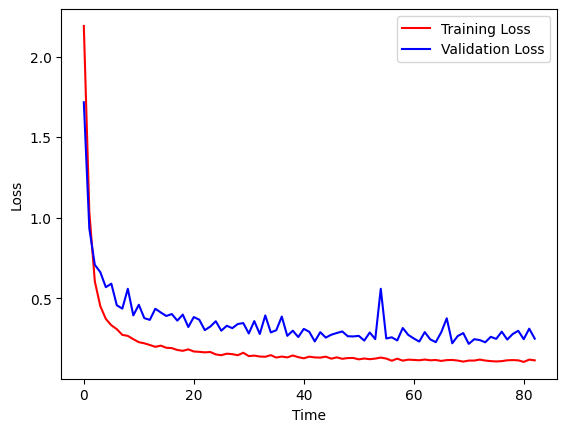

In [22]:
# plot losses
plt.plot(train_losses, 'r', label='Training Loss')
plt.plot(valid_losses, 'b', label='Validation Loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.legend()

c:\Users\enes_\.virtualenvs\Assignment_3-QMV5D0kI\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Predicted class:  Speed limit (50km/h) (with probability 1.0)
True class:  Speed limit (50km/h)


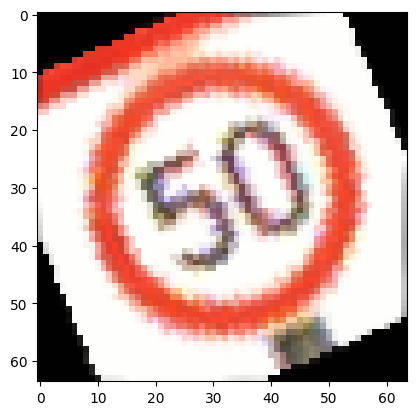

Predicted class:  Speed limit (30km/h) (with probability 1.0)
True class:  Speed limit (30km/h)


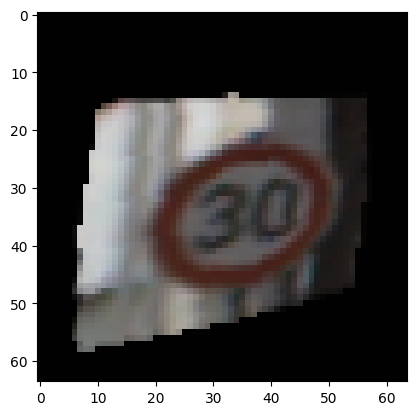

Predicted class:  General caution (with probability 1.0)
True class:  General caution


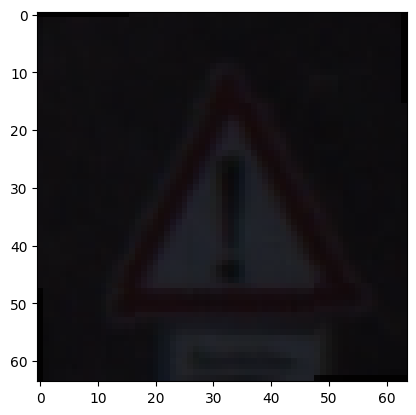

Predicted class:  Traffic signals (with probability 1.0)
True class:  Traffic signals


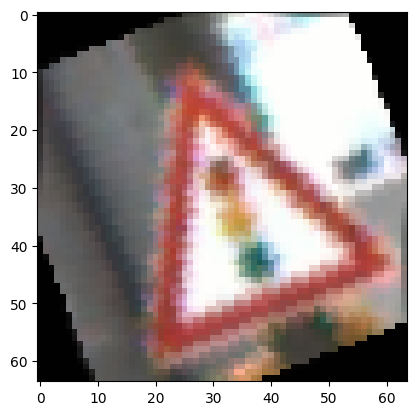

Predicted class:  Roundabout mandatory (with probability 1.0)
True class:  Keep right


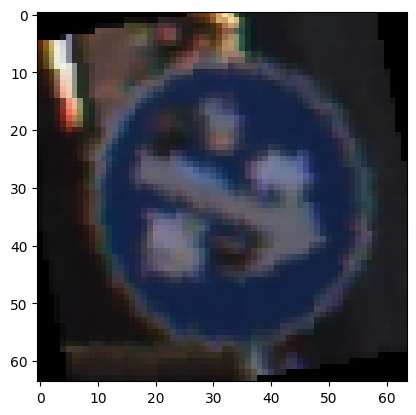

Predicted class:  No passing for vehicles over 3.5 metric tons (with probability 1.0)
True class:  No passing for vehicles over 3.5 metric tons


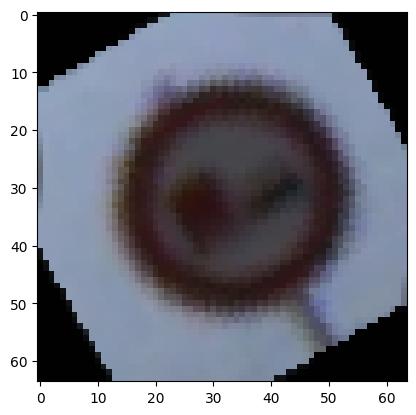

Predicted class:  Turn right ahead (with probability 1.0)
True class:  Turn right ahead


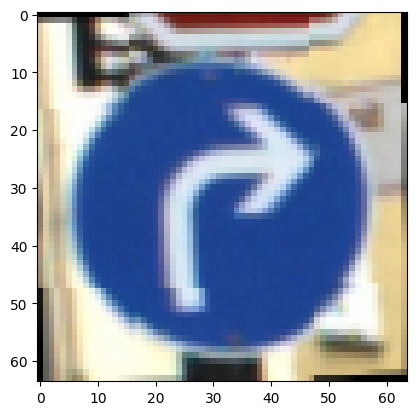

Predicted class:  Speed limit (100km/h) (with probability 1.0)
True class:  Speed limit (100km/h)


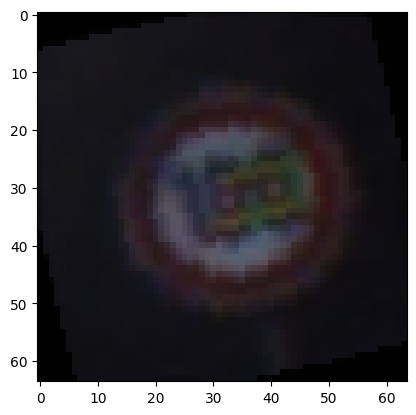

Predicted class:  Turn right ahead (with probability 1.0)
True class:  Turn right ahead


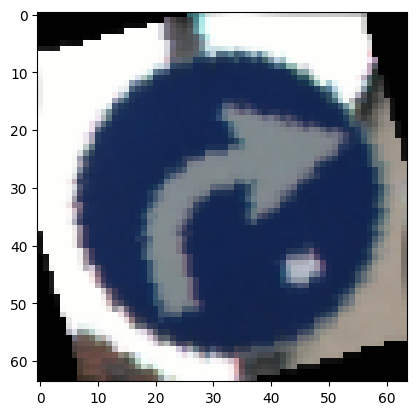

Predicted class:  Beware of ice/snow (with probability 0.7)
True class:  Right-of-way at the next intersection


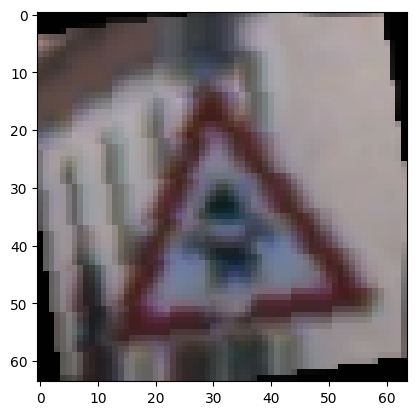

In [27]:
# plot 10 random images with predictions and labels
for i in range(10):
    dataiter = iter(testLoader)
    image, label = next(dataiter)

    outputs = model_cnn_2.forward(image)
    max_pred, class_pred = torch.max(outputs, 1)
    prob = torch.exp(max_pred)
    print("Predicted class: ", classes[class_pred.item()], "(with probability %1.1f)" % prob.item())
    print("True class: ", classes[label.item()])

    show_image(torchvision.utils.make_grid(image))

In [25]:
# final evaluation on testset
final_eval(model_cnn_2, testLoader)

Final accuracy on test dataset: 0.929
